<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D2_CognitiveStructures/student/W2D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D2_CognitiveStructures/student/W2D2_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Generalizing representations

**Week 2, Day 2: Cognitive Structures**

**By Neuromatch Academy**

__Content creators:__ Michael Furlong

__Content reviewers:__ Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

___


# Tutorial Objectives

*Estimated timing of tutorial: 1 hour 20 minutes*

In this tutorial, you will observe how the VSAs methods can be applied in structures and environments to allow for efficient generalization.

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "kj6p3"

print(f"If you want to download the slides: 'https://osf.io/download/{link_id}'")

IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'https://osf.io/download/kj6p3'


---
# Setup



In [5]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W2D2_T3"

In [3]:
# @title Install dependencies
# @markdown

# Install sspspace
!pip install git+https://github.com/ctn-waterloo/sspspace@neuromatch --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
# Imports

#working with data
import numpy as np

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets

#modeling
import sspspace
from scipy.special import softmax
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [9]:
# @title Plotting functions

def plot_vectors(concepts, labels, shape = (32, 32)):
    """
    Plot vector symbols associated with the given concepts.

    Inputs:
    - concepts (list of sspspace.ssp.SSP): list of concepts which contain associated vectors.
    - labels (list of str): list of strings which represent concepts.
    - shape (tuple, default = (32, 32)): desired image shape.
    """
    with plt.xkcd():
        n = len(concepts)
        for i in range(len(concepts)):
            plt.subplot(1,n,i+1)
            plt.imshow(concepts[i].view(dtype=float,type=np.ndarray).reshape(shape), cmap='Greys')
            plt.xticks([])
            plt.yticks([])
            plt.title(labels[i])

def plot_similarity_matrix(sim_mat, labels, values = False):
    """
    Plot the similarity matrix between vectors.

    Inputs:
    - sim_mat (numpy.ndarray): similarity matrix between vectors.
    - labels (list of str): list of strings which represent concepts.
    - values (bool): True if we would like to plot values of similarity too.
    """
    with plt.xkcd():
        plt.imshow(sim_mat, cmap='Greys')
        plt.colorbar()
        plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right", rotation_mode="anchor")
        plt.yticks(np.arange(len(labels)), labels)
        if values:
            for x in range(sim_mat.shape[1]):
                for y in range(sim_mat.shape[0]):
                    plt.text(x, y, f"{sim_mat[y, x]:.2f}", fontsize = 8, ha="center", va="center", color="green")
        plt.title('Similarity between vector-symbols')
        plt.xlabel('Symbols')
        plt.ylabel('Symbols')
        plt.show()

def plot_line_similarity_matrix(sim_mat, xaxis_ticks, multiple_objects = True, labels = None, title = "Awesome title!"):
    """
    Plot similarirty matrix (or vector if multiple_objects is False) as lines.

    Inputs:
    - sim_mat (numpy.ndarray): similarity matrix between vectors.
    - xaxis_ticks (list): list of ticks to put in x-axis.
    - multiple_objects (bool, default = True): True if there are a couple of objects to plot similarity.
    - labels (list, default = None): labels to plot.
    - title (str): title of the plot.
    """
    with plt.xkcd():
        if multiple_objects:
            for idx, integer_sims in enumerate(sim_mat):
                if labels:
                    plt.plot(xaxis_ticks, integer_sims.flatten(), label=f'$\phi$[{idx+1}]', marker='o', ls='--')
                else:
                    plt.plot(xaxis_ticks, integer_sims.flatten(), marker='o', ls='--')
        else:
            plt.plot(xaxis_ticks,sim_mat.flatten(), ls='--',marker='o')

    plt.ylabel('Similarity')
    plt.xlabel('n')
    plt.xticks(xaxis_ticks)
    if labels:
        plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

def plot_double_line_similarity_matrix(sim_mat, xaxis_ticks, labels, title):
    """
    Plot similarirty matrix (or vector if multiple_objects is False) as lines for two different matrices.

    Inputs:
    - sim_mat (numpy.ndarray): list of similarity matrix between vectors.
    - xaxis_ticks (list): list of ticks to put in x-axis.
    - multiple_objects (bool, default = True): True if there are a couple of objects to plot similarity.
    - labels (list): labels to plot.
    - title (str): title of the plot.
    """
    with plt.xkcd():
        plt.plot(xaxis_ticks,sim_mat[0].flatten(), ls='--',marker='o', label = labels[0])
        plt.plot(xaxis_ticks,sim_mat[1].flatten(), ls='--',marker='o', label = labels[1])
    plt.ylabel('Similarity')
    plt.xlabel('n')
    plt.xticks(xaxis_ticks)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

def plot_real_valued_line_similarity(sim_mat, x_range, title):
    """
    Inputs:
    - sim_mat (numpy.ndarray): similarity matrix between vectors.
    - x_range (numpy.ndarray): x-axis range.
    - title (str): title of the plot.
    """
    with plt.xkcd():
        plt.plot(x_range, sims)
    plt.xlabel('x')
    plt.ylabel('Similarity')
    plt.title(title)

def plot_3d_function(X, Y, zs, titles):
    """Plot 3D function.

    Inputs:
    - X (list): list of np.ndarray of x-values.
    - Y (list): list of np.ndarray of y-values.
    - zs (list): list of np.ndarray of z-values.
    - titles (list): list of titles of the plot.
    """
    with plt.xkcd():
        fig = plt.figure(figsize=(10,10))
        for index, (x, y, z) in enumerate(zip(X, Y, zs)):
            fig.add_subplot(1, len(X), index + 1, projection='3d')
            plt.gca().plot_surface(x,y,z.reshape(x.shape),cmap='plasma', antialiased=False, linewidth=0)
            plt.xlabel(r'$x_{1}$')
            plt.ylabel(r'$x_{2}$')
            plt.gca().set_zlabel(r'$f(\mathbf{x})$')
            plt.title(titles[index])
        plt.show()

def plot_performance(bound_performance, bundle_performance, test_sizes, title):
    """Plot RMSE values for two different representations of the input data.

    Inputs:
    - bound_performance (list): list of RMSE for bound representation.
    - bundle_performance (list): list of RMSE for bundle representation.
    - test_sizes (list): x-axis.
    - title (str): title of the plot.
    """
    with plt.xkcd():
        plt.plot(test_sizes, bound_performance, label='Bound Representation')
        plt.plot(test_sizes, bundle_performance, label='Bundling Representation', ls='--')
        plt.legend()
        plt.title(title)
        plt.ylabel('RMSE (a.u.)')
        plt.xlabel('Test Set Fraction')
        plt.show()

def plot_2d_similarity(sims, obj_names, size, title_argmax = False):
    """
    Plot 2D similarity between query points (grid) and the ones associated with the objects.

    Inputs:
    - sims (list): list of similarity values for each of the objects.
    - obj_names (list): list of object names.
    - size (tuple): to reshape the similarities.
    - title_argmax (bool, default = False): looks for the point coordinates as arg max from all similarity value.
    """
    ticks = [0,24,49,74,99]
    ticklabels = [-5,-2,0,2,5]
    with plt.xkcd():
        for obj_idx, obj in enumerate(obj_names):
            plt.subplot(1,len(obj_names), 1+obj_idx)
            plt.imshow(sims[obj_idx].reshape(size), origin='lower', vmin=-1, vmax=1)
            plt.gca().set_xticks(ticks)
            plt.gca().set_xticklabels(ticklabels)
            if obj_idx == 0:
                plt.gca().set_yticks(ticks)
                plt.gca().set_yticklabels(ticklabels)
            else:
                plt.gca().set_yticks([])
            if not title_argmax:
                plt.title(f'{obj}, {positions[obj_idx]}')
            else:
                plt.title(f'{obj}, {query_xs[sims[obj_idx].argmax()]}')
        plt.show()

def plot_unbinding_objects_map(sims, positions, query_xs, size):
    """
    Plot 2D similarity between query points (grid) and the unbinded from the objects map.

    Inputs:
    - sims (np.ndarray): similarity values for each of the query points with the map.
    - positions (np.ndarray): positions of the objects.
    - query_xs (np.ndarray): grid points.
    - size (tuple): to reshape the similarities.

    """
    ticks = [0,24,49,74,99]
    ticklabels = [-5,-2,0,2,5]
    with plt.xkcd():
        plt.imshow(sims.reshape(size), origin='lower')

        for idx, marker in enumerate(['o','s','^']):
            plt.scatter(*get_coordinate(positions[idx,:], query_xs, size), marker=marker,s=100)

        plt.gca().set_xticks(ticks)
        plt.gca().set_xticklabels(ticklabels)
        plt.gca().set_yticks(ticks)
        plt.gca().set_yticklabels(ticklabels)
        plt.title(f'All Object Locations')
        plt.show()

def plot_unbinding_positions_map(sims, positions, obj_names):
    """
    Plot 2D similarity between query points (grid) and the unbinded from the positions map.

    Inputs:
    - sims (np.ndarray): similarity values for each of the query points with the map.
    - positions (np.ndarray): test positions to query.
    - obj_names (list): names of the objects for labels.
    - size (tuple): to reshape the similarities.
    """
    with plt.xkcd():
        plt.figure(figsize=(25,5))
        for pos_idx, pos in enumerate(positions):
            plt.subplot(1,len(test_positions), 1+pos_idx)
            plt.bar([1,2,3], sims[pos_idx])
            plt.ylim([-0.3,1.05])
            plt.gca().set_xticks([1,2,3])
            plt.gca().set_xticklabels(obj_names, rotation=90)
            if pos_idx != 0:
                plt.gca().set_yticks([])
            plt.title(f'Symbols at {pos}')
        plt.show()

def plot_training_and_choice(losses, sims, ant_names, cons_names, action_names):
    """
    Plot loss progression over training as well as predicted similarities for given rules / correct solutions.

    Inputs:
    - losses (list): list of loss values.
    - sims (list): list of similartiy matrices.
    - ant_names (list): list of antecedance names.
    - cons_names (list): list of consequent names.
    - action_names (list): full list of concepts.
    """
    with plt.xkcd():
        plt.subplot(1, len(ant_names) + 1, 1)
        plt.plot(losses)
        plt.xlabel('Training number')
        plt.ylabel('Loss')
        plt.title('Training Error')
        index = 1
        for ant_name, cons_name, sim in zip(ant_names, cons_names, sims):
            index += 1
            plt.subplot(1, len(ant_names) + 1, index)
            plt.bar(range(len(action_names)), sim.flatten())
            plt.gca().set_xticks(range(len(action_names)))
            plt.gca().set_xticklabels(action_names, rotation=90)
            plt.title(f'{ant_name}, not*{cons_name}')

def plot_choice(sims, ant_names, cons_names, action_names):
    """
    Plot predicted similarities for given rules / correct solutions.
    """
    with plt.xkcd():
        index = 0
        for ant_name, cons_name, sim in zip(ant_names, cons_names, sims):
            index += 1
            plt.subplot(1, len(ant_names) + 1, index)
            plt.bar(range(len(action_names)), sim.flatten())
            plt.gca().set_xticks(range(len(action_names)))
            plt.gca().set_xticklabels(action_names, rotation=90)
            plt.ylabel("Similarity")
            plt.title(f'{ant_name}, not*{cons_name}')

In [8]:
# @title Helper functions

def get_model(xs, ys, test_size):
    """Fit linear regression to the given data.

    Inputs:
    - xs (np.ndarray): input data.
    - ys (np.ndarray): outpu data.
    - test_size (float): fraction of data to use for test.
    """
    X_train, X_test, y_train, y_test = train_test_split(xs, ys, random_state=1, test_size=test_size)
    return LinearRegression().fit(X_train, y_train)

def get_coordinate(x, positions, target_shape):
    """Return the closest column and row coordinates for the given position.

    Inputs:
    - x (np.ndarray): query position.
    - positions (np.ndarray): all positions.
    - target_shape (tuple): shape of the grid.

    Outputs:
    - coordinates (tuple): column and row positions.
    """
    idx = np.argmin(np.linalg.norm(x - positions, axis=1))
    c = idx % target_shape[1]
    r = idx // target_shape[1]
    return (c,r)

In [7]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)

set_seed(seed = 42)

---

# Section 1: Generalization - Wason Card Task

One of the powerful benefits of using these structured representations is being able to generalize to other circumstances.  To demonstrate this, we are going to show how we can use a simple learning rule to learn to extract a generalized rule to different circumstances.

In [ ]:
# @title Video 1: Wason Card Task Intro

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'KqMMEDjhbKI')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_wason_card_task_intro")

## Coding Exercise 1: Wason Card Task

We are going to test the generalization property on the Wason Card Task, where a person is told a rule of the form "if the card is even, then the back is blue", they are then presented with a number of cards with either an odd number, an even number, a red back, or a blue back.  The participant is asked which cards they have to flip to determine that the rule is true.

In this case, the participant needs to flip only the even card(s), as the rule does not state whether or not odd numbers can have blue backs. 

At first, we will define all needed concepts. For all noun concepts we would also like to have `not concept` presented in the space, please complete missing code parts.

In [6]:
set_seed(42)

card_states = ['red','blue','odd','even','not','green','prime','implies','ant','relation','cons']
encoder = sspspace.DiscreteSPSpace(card_states, ssp_dim=1024, optimize=False)
vocab = {c:encoder.encode(c) for c in card_states}

###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete creating `not x` concepts.")
###################################################################

for a in ['red','blue','odd','even','green','prime']:
    vocab[f'not*{a}'] = vocab[...] * vocab[a]

action_names = ['red','blue','odd','even','green','prime','not*red','not*blue','not*odd','not*even','not*green','not*prime']
action_space = np.array([vocab[x] for x in action_names]).squeeze()

NameError: name 'set_seed' is not defined

In [11]:
#to_remove solution

set_seed(42)

card_states = ['red','blue','odd','even','not','green','prime','implies','ant','relation','cons']
encoder = sspspace.DiscreteSPSpace(card_states, ssp_dim=1024, optimize=False)
vocab = {c:encoder.encode(c) for c in card_states}

for a in ['red','blue','odd','even','green','prime']:
    vocab[f'not*{a}'] = vocab['not'] * vocab[a]

action_names = ['red','blue','odd','even','green','prime','not*red','not*blue','not*odd','not*even','not*green','not*prime']
action_space = np.array([vocab[x] for x in action_names]).squeeze()

Now, we are going to set up a simple perceptron-style learning rule, using the HRR (Holographic Reduced Representations) algebra.  We are going to learn a target transformation, $T$, such that given a learning rule, $A^{*} = T\circledast R$, where $A^{*}$ is the antecedance value bundled with $\texttt{not}$ bound with the consequent value and $R$ is the learning rule.

Rules themselves are going to be composed as country data structures from the previous section. `ant`, `relation` and `cons` are extra concepts which define the structure and which will bind to the specific instances. In the cell below, let us define two rules:

$$\text{blue} \implies \text{even}$$
$$\text{odd} \implies \text{green}$$

In [12]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete creating rules as defined above.")
###################################################################

rules = [
    (vocab['ant'] * vocab['blue'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab[...]).normalize(),
    (vocab[...] * vocab[...] + vocab[...] * vocab[...] + vocab[...] * vocab[...]).normalize(),
]

NotImplementedError: Student exercise: complete creating rules as defined above.

In [13]:
#to_remove solution

rules = [
    (vocab['ant'] * vocab['blue'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['even']).normalize(),
    (vocab['ant'] * vocab['odd'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['green']).normalize(),
]

Now, we are ready to derive the transformation! For that, we will iterate through the rules and solutions for specified number of iterations and update it as the following:

$$T \leftarrow T - \text{lr}*(A^{*} * \sim R)$$

where $\text{lr}$ is learning rate constant value. Indeed, as $A^{*} = T\circledast R$, it makes sense to unbind learning rule to get the current transformation prediction.

We will also compute loss progression over the time and log loss function between perfect similarity (ones only for antecedance value and not consequent one) and the one we obtain between prediciton for current transformation and full action space. Complete missing parts of the code in the next cell to complete training.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete training loop.")
###################################################################

num_iters = 500
losses = []
sims = []
lr = 1e-1
ant_names = ["blue", "odd"]
cons_names = ["even", "green"]

transform = np.zeros((1,encoder.ssp_dim))
for i in range(num_iters):
    loss = 0
    for rule, ant_name, cons_name in zip(rules, ant_names, cons_names):
        
        #perfect similarity
        y_true = np.eye(len(action_names))[action_names.index(ant_name),:] + np.eye(len(action_names))[4+action_names.index(cons_name),:]

        #prediction with current transform (a_hat = transform * rule)
        a_hat = sspspace.SSP(transform) * ...

        #similarity with current transform
        sim_mat = np.einsum('nd,md->nm', action_space, a_hat)

        #cleanup
        y_hat = softmax(sim_mat)

        #true solution (a* = ant_name + not * cons_name)
        a_true = (vocab[ant_name] + vocab['not']*vocab[...]).normalize()

        #calculate loss
        loss += log_loss(y_true, y_hat)

        #update transform (T <- T - lr * (A* * (~rule)))
        transform -= (lr) * (... - np.array(... * ~...))
        transform = transform / np.linalg.norm(transform)

        #save predicted similarities if it is last iteration
        if i == num_iters - 1:
            sims.append(sim_mat)

    #save loss
    losses.append(np.copy(loss))

In [14]:
#to_remove solution

num_iters = 500
losses = []
sims = []
lr = 1e-1
ant_names = ["blue", "odd"]
cons_names = ["even", "green"]

transform = np.zeros((1,encoder.ssp_dim))
for i in range(num_iters):
    loss = 0
    for rule, ant_name, cons_name in zip(rules, ant_names, cons_names):
        
        #perfect similarity
        y_true = np.eye(len(action_names))[action_names.index(ant_name),:] + np.eye(len(action_names))[4+action_names.index(cons_name),:]

        #prediction with current transform (a_hat = transform * rule)
        a_hat = sspspace.SSP(transform) * rule

        #similarity with current transform
        sim_mat = np.einsum('nd,md->nm', action_space, a_hat)

        #cleanup
        y_hat = softmax(sim_mat)

        #true solution (a* = ant_name + not * cons_name)
        a_true = (vocab[ant_name] + vocab['not']*vocab[cons_name]).normalize()

        #calculate loss
        loss += log_loss(y_true, y_hat)

        #update transform (T <- T - lr * (A* * (~rule)))
        transform -= (lr) * (transform - np.array(a_true * ~rule))
        transform = transform / np.linalg.norm(transform)

        #save predicted similarities if it is last iteration
        if i == num_iters - 1:
            sims.append(sim_mat)

    #save loss
    losses.append(np.copy(loss))

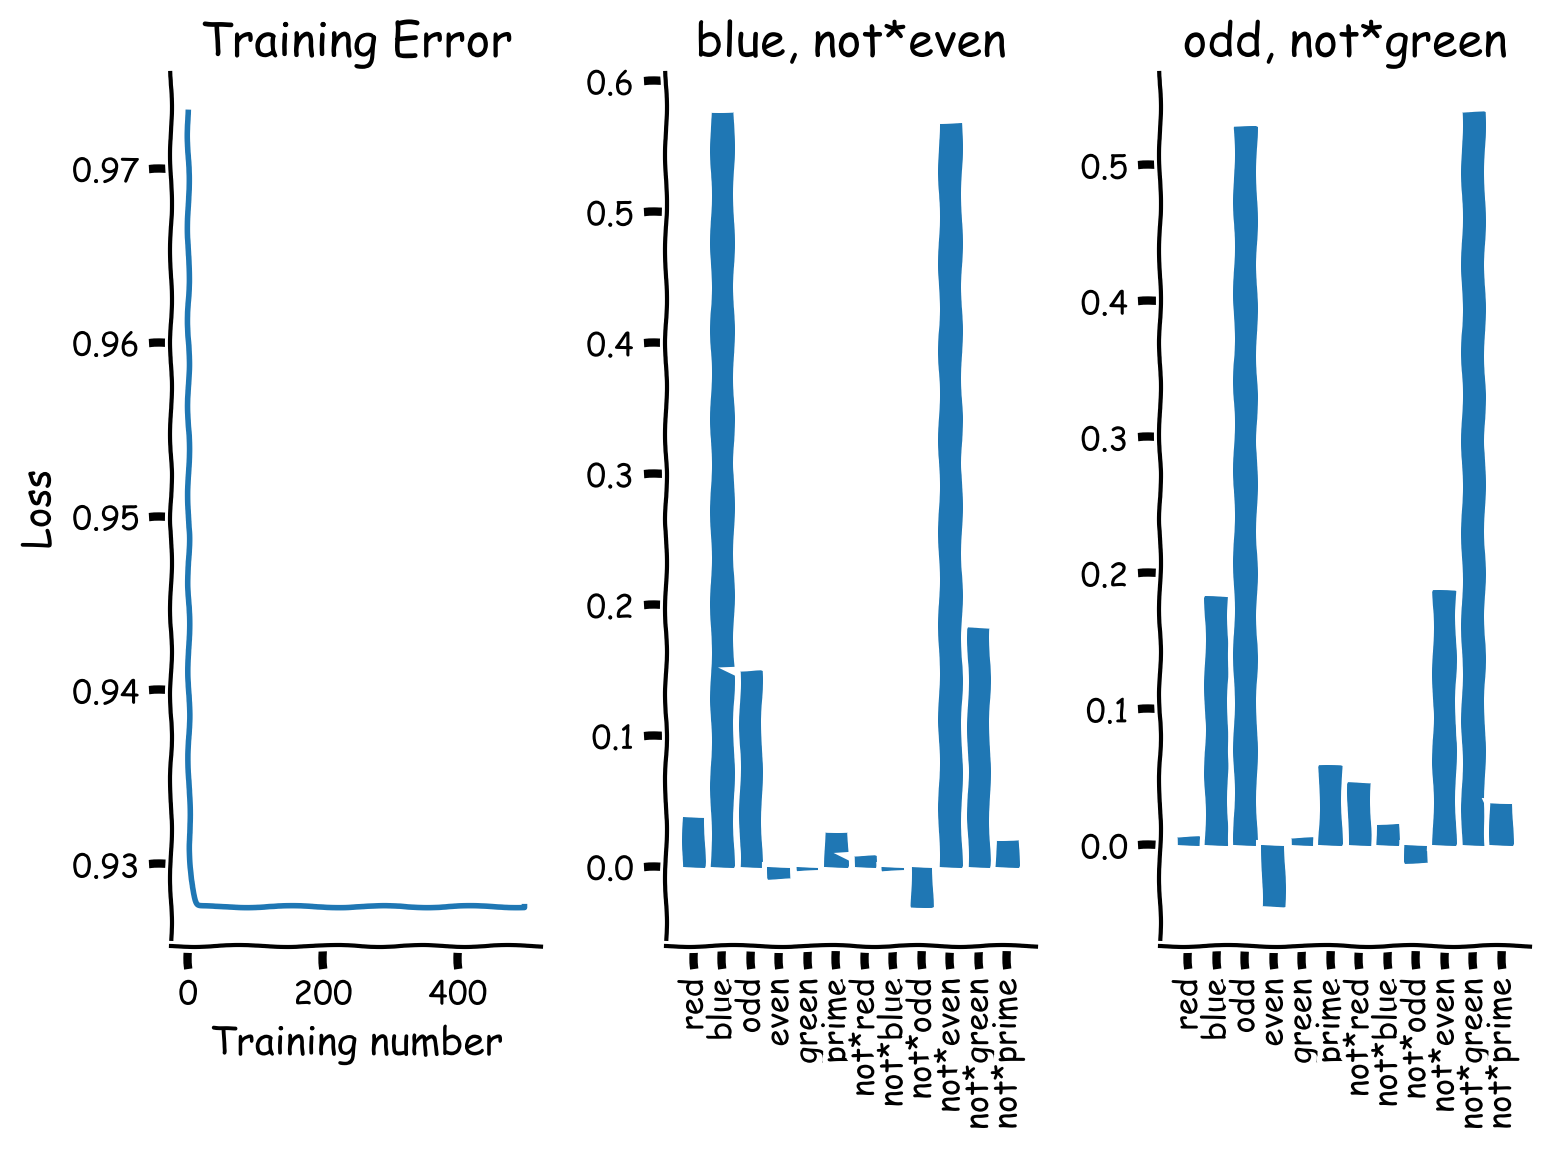

In [15]:
plot_training_and_choice(losses, sims, ant_names, cons_names, action_names)

Let's see what happens when we test it on a new rule it hasn't seen before. This time we will use the rule that $\text{red} \implies \text{prime}$. Your task is to complete new rule in the cell below and observe the results.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete new rule and predict for it.")
###################################################################

new_rule = (vocab['ant'] * vocab[...] + vocab['relation'] * ... + vocab['cons'] * vocab[...]).normalize()

#apply transform on new rule to test the generalization of the transform
a_hat = sspspace.SSP(transform) * ...

new_sims = np.einsum('nd,md->nm', action_space, a_hat)
y_hat = softmax(new_sims)

In [16]:
#to_remove solution

new_rule = (vocab['ant'] * vocab['red'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['prime']).normalize()

#apply transform on new rule to test the generalization of the transform
a_hat = sspspace.SSP(transform) * new_rule

new_sims = np.einsum('nd,md->nm', action_space, a_hat)
y_hat = softmax(new_sims)

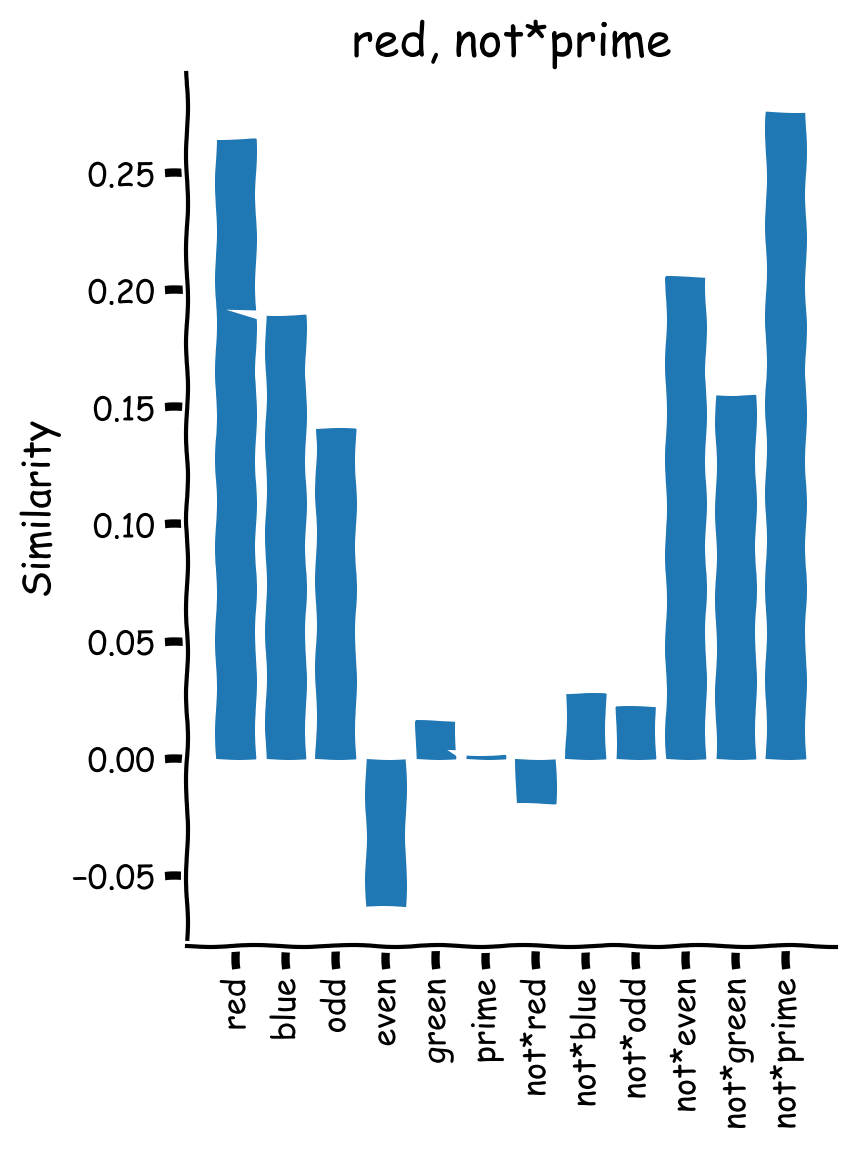

In [17]:
plot_choice([new_sims], ["red"], ["prime"], action_names)

Let's compare how a standard MLP that isn't aware of the structure in the representation performs. Here, features are going to be the rules and output - solutions. Complete the code below.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete MLP training.")
###################################################################

#features - rules
X_train = np.array(...).squeeze()

#output - a* for each rule
y_train = np.array([
    (vocab[ant_names[0]] + vocab['not']*vocab[cons_names[0]]).normalize(),
    (vocab[ant_names[1]] + vocab['not']*vocab[cons_names[1]]).normalize(),
]).squeeze()

regr = MLPRegressor(random_state=1, hidden_layer_sizes=(1024,1024), max_iter=1000).fit(..., ...)

a_mlp = regr.predict(new_rule)

mlp_sims = np.einsum('nd,md->nm', action_space, a_mlp)

In [18]:
#to_remove solution

#features - rules
X_train = np.array(rules).squeeze()

#output - a* for each rule
y_train = np.array([
    (vocab[ant_names[0]] + vocab['not']*vocab[cons_names[0]]).normalize(),
    (vocab[ant_names[1]] + vocab['not']*vocab[cons_names[1]]).normalize(),
]).squeeze()

regr = MLPRegressor(random_state=1, hidden_layer_sizes=(1024,1024), max_iter=1000).fit(X_train, y_train)

a_mlp = regr.predict(new_rule)

mlp_sims = np.einsum('nd,md->nm', action_space, a_mlp)

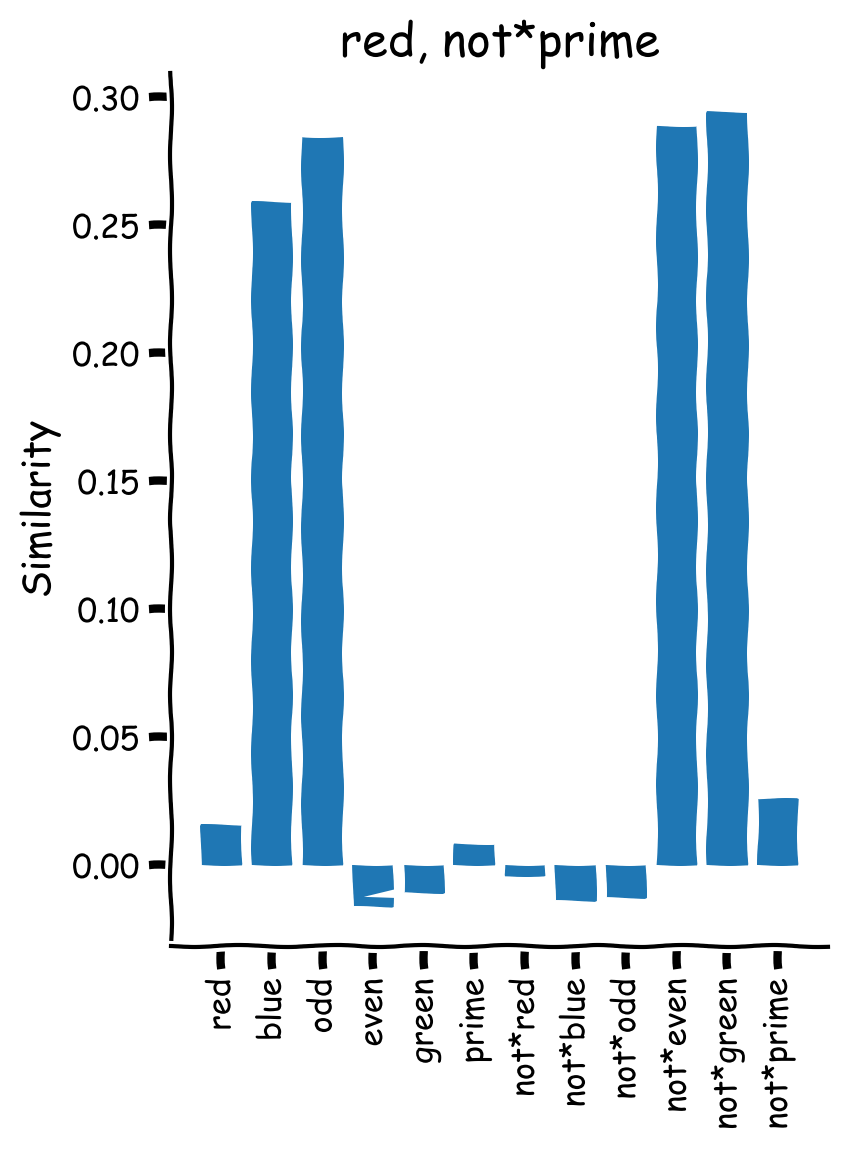

In [19]:
plot_choice([mlp_sims], ["red"], ["prime"], action_names)

As you can see, this model, even though it is a more expressive neural network, simply learns to predict the values it had seen before, when presented with a novel stimulus.

In [ ]:
# @title Video 2: Wason Card Task Outro

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'rV3oZXLFrb4')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_wason_card_task_outro")

---

# Section 2: Sample Efficient Learning

Estimated timing to here from start of tutorial: 30 minutes

In this section we will take a look at how imposing an inductive bias on our feature space can result in more sample-efficient learning. 

In [ ]:
# @title Video 3: Function Learning and Inductive Bias
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'NgwMVgaTIbY')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_function_learning_and_inductive_bias")

## Coding Exercise 2: Additive Function


We will start with an additive function, the Rastrigin function, defined 
$$
f(\mathbf{x}) = 10*d + \sum_{i=1}^{d} (x_{i}^{2} - 10 \cos(2 \pi x_{i}))
$$

where $d$ is the dimensionality of the input vector. In the cell below complete missing parts of the function which computes values of the Rastrigin function given the input array.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete the Rastrigin function.")
###################################################################

def rastrigin(x):
    """Compute Rastrigin function for given array of d-dimenstional vectors.

    Inputs:
    - x (np.ndarray of shape (n, d)): n d-dimensional vectors.

    Outputs:
    - y (np.ndarray of shape (n, 1)): Rastrigin function value for each of the vectors.
    """
    return 10 * x.shape[1] + np.sum(... - 10 * np.cos(2*np.pi*...), axis=1)

In [20]:
#to_remove solution

def rastrigin(x):
    """Compute Rastrigin function for given array of d-dimenstional vectors.

    Inputs:
    - x (np.ndarray of shape (n, d)): n d-dimensional vectors.

    Outputs:
    - y (np.ndarray of shape (n, 1)): Rastrigin function value for each of the vectors.
    """
    return 10 * x.shape[1] + np.sum(x**2 - 10 * np.cos(2*np.pi*x), axis=1)

In [21]:
# this code creates 10000 2-dimensional vectors which are going to be served as input to the function (thus, output is of shape (10000, 1))
x0 = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x0,x0)
xs = np.vstack((X.flatten(), Y.flatten())).T

ys_rastrigin = rastrigin(xs)

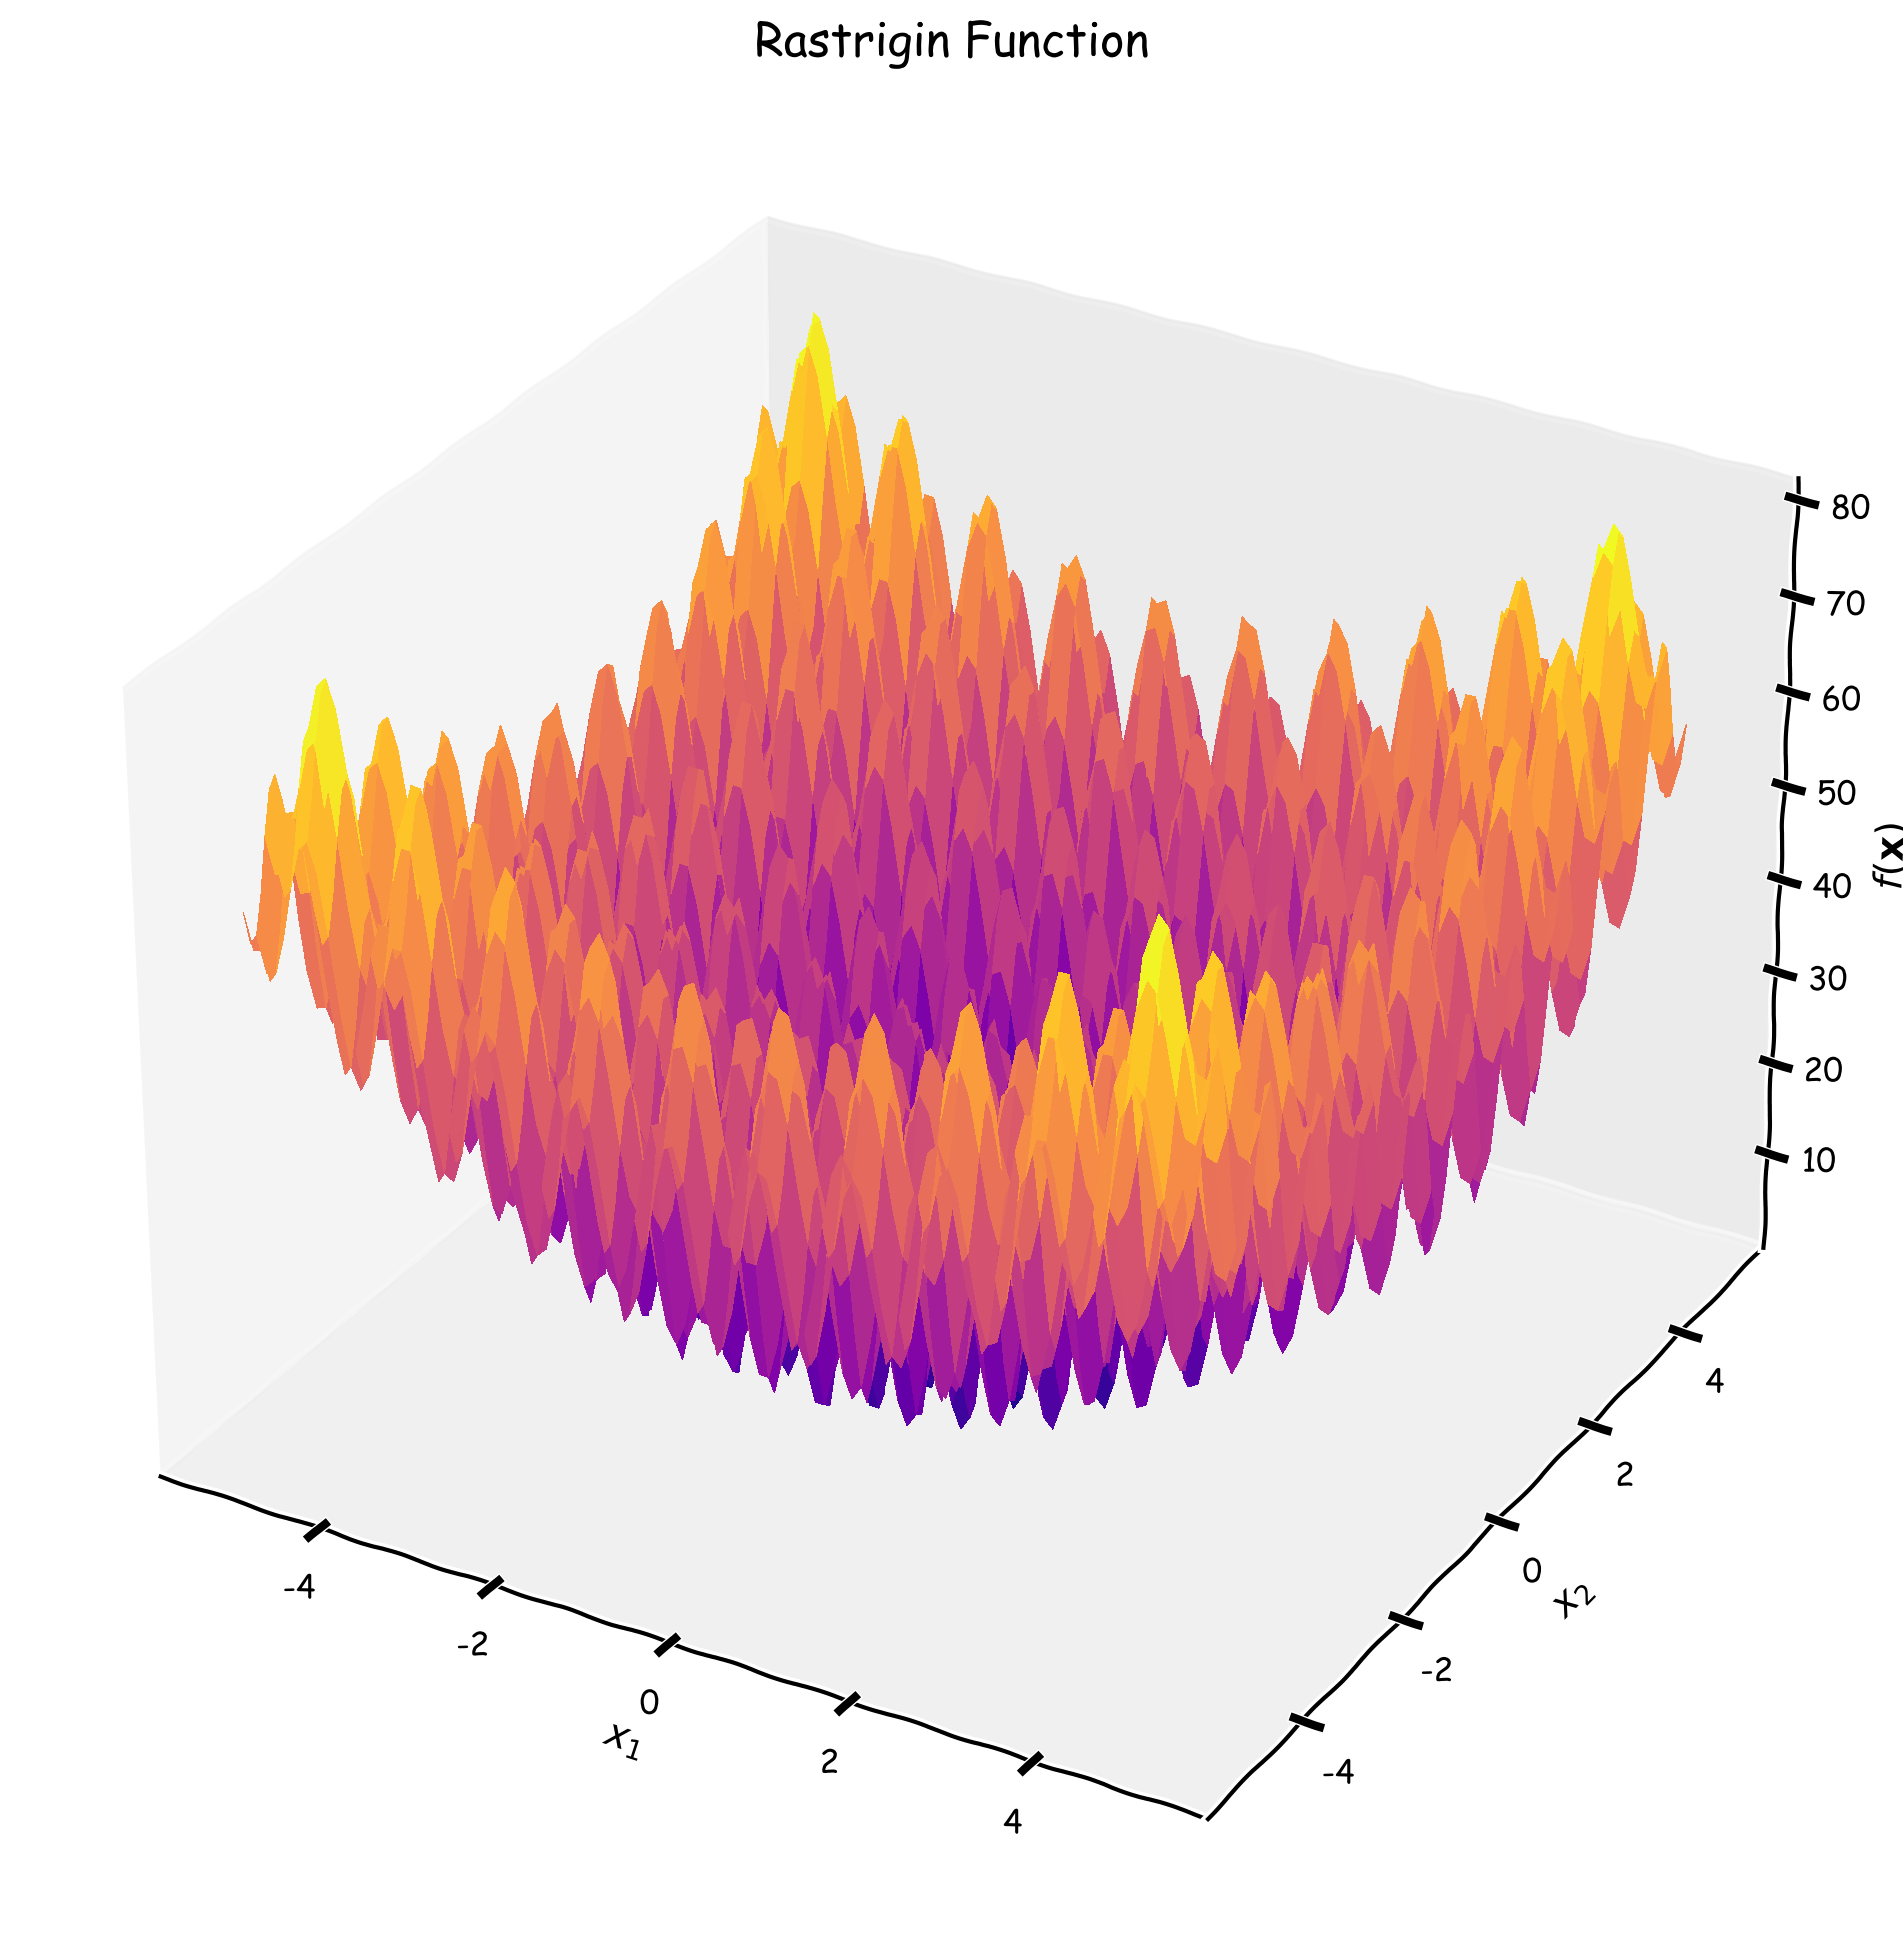

In [22]:
plot_3d_function([X],[Y], [ys_rastrigin.reshape(X.shape)], ['Rastrigin Function'])

Now, we are going to see which of the inductive biases (suggested mechanism underlying input data) will be more efficient in training the linear regression to get values of the Rastrigin function. For that, we will simply encode 2D input vectors `xs` (we call it 'bound') and with using bundling (encode each of the dimensions separately and then bundle them together). 

In [24]:
set_seed(42)

ssp_space = sspspace.RandomSSPSpace(domain_dim=2, ssp_dim=1024)
bound_phis = ssp_space.encode(xs)

ssp_space0 = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=1024)
ssp_space1 = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=1024)

#remember that input to `encode` should be 2-dimensional, thus we need to create extra dimension by applying [:,None]
bundle_phis = ssp_space0.encode(xs[:,0][:,None]) + ssp_space1.encode(xs[:,1][:,None])

Now, let us define modeling attributes: we will have a couple of different `test_sizes` and we will fit linear regression for each of them right in the loop; then, for each of the models we will evaluate its fit based on RMSE loss.

In [25]:
def loss(y_true, y_pred):
    """Calculate RMSE loss between true and predicted values (note, that loss is not normalized by the shape).

    Inputs:
    - y_true (np.ndarray): true values.
    - y_pred (np.ndarray): predicted values.

    Outputs:
    - loss (float): loss value.
    """
    return np.sqrt(np.mean((y_true - y_pred)**2))

def test_performance(xs, ys, test_sizes):
    """Fit linear regression to the provided data and evaluate the performance with RMSE loss for different test sizes.

    Inputs:
    - xs (np.ndarray): input data.
    - ys (np.ndarray): output data.
    - test_size (list): list of the test sizes.
    """
    performance = []

    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(xs, ys, random_state=1, test_size=test_size)
        regr = LinearRegression().fit(X_train, y_train)
        performance.append(np.copy(loss(y_test, regr.predict(X_test))))
    return performance

Now we are ready to traing the models on two different inductive biases of the input data.

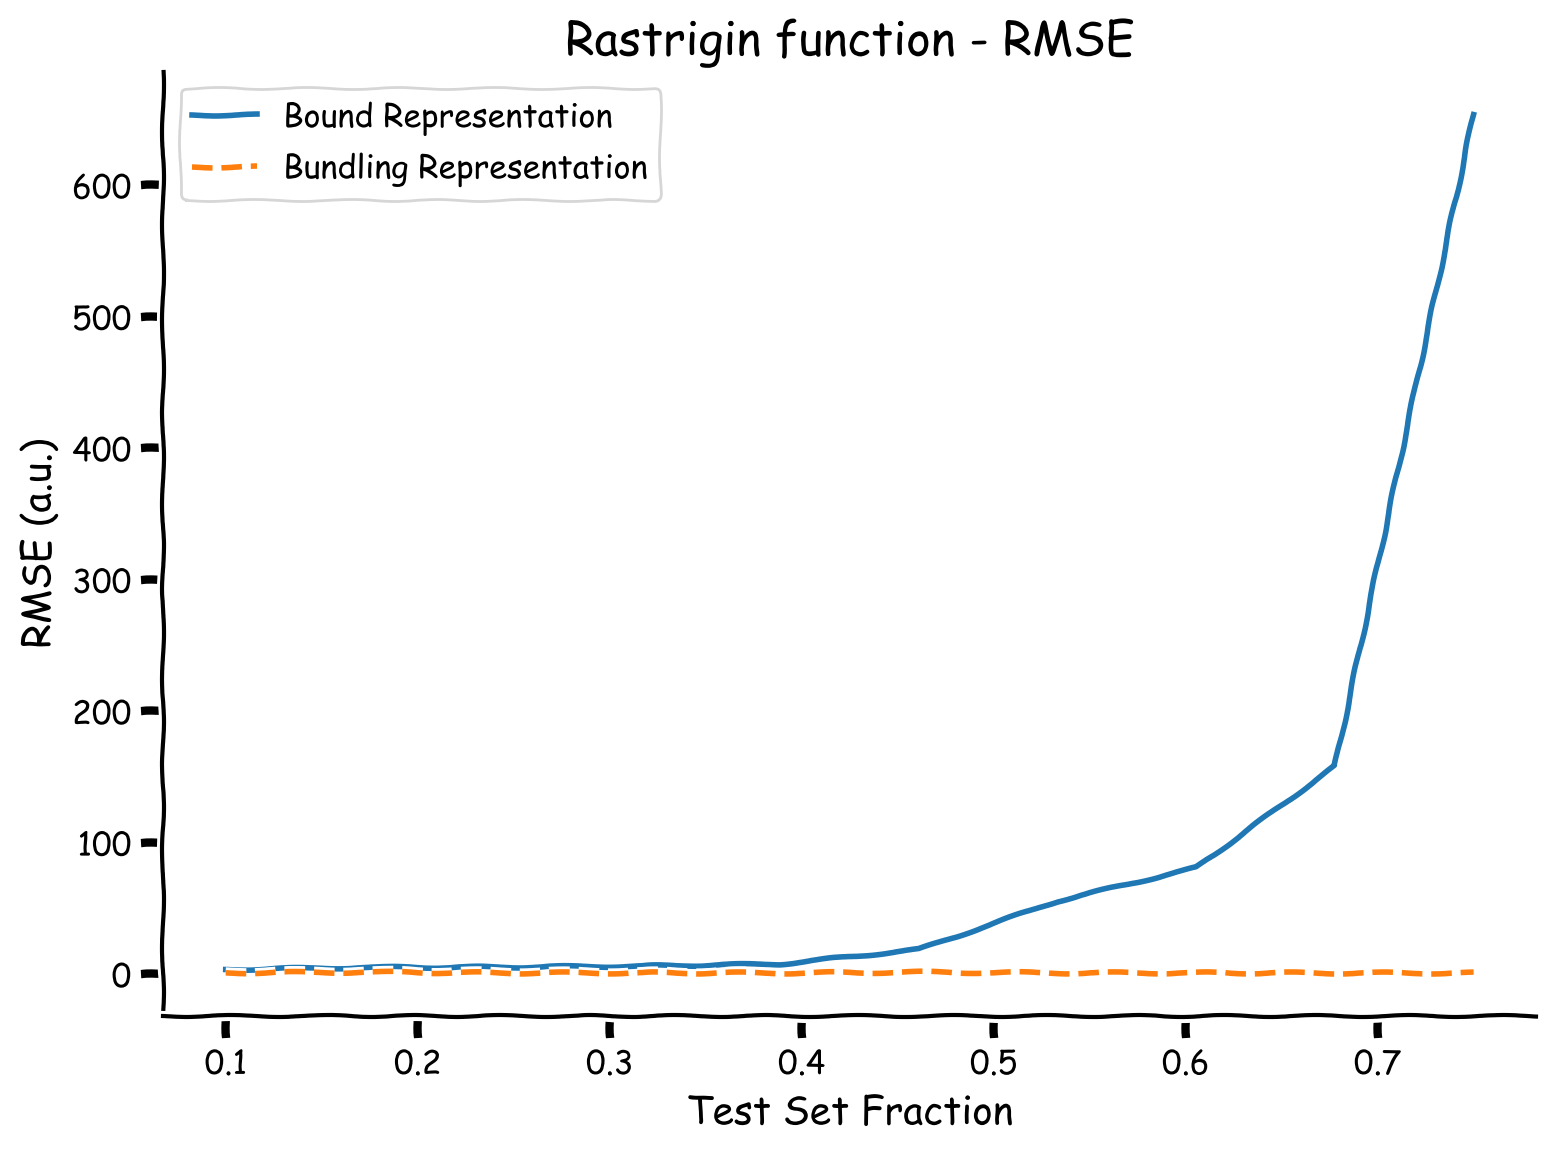

In [26]:
test_sizes = np.linspace(0.1,0.75,10)
bound_performance = test_performance(bound_phis, ys_rastrigin, test_sizes)
bundle_performance = test_performance(bundle_phis, ys_rastrigin, test_sizes)
plot_performance(bound_performance, bundle_performance, test_sizes, "Rastrigin function - RMSE")

What a drastic difference! Let us evaluate visually the performance with `test_size = 0.7`.

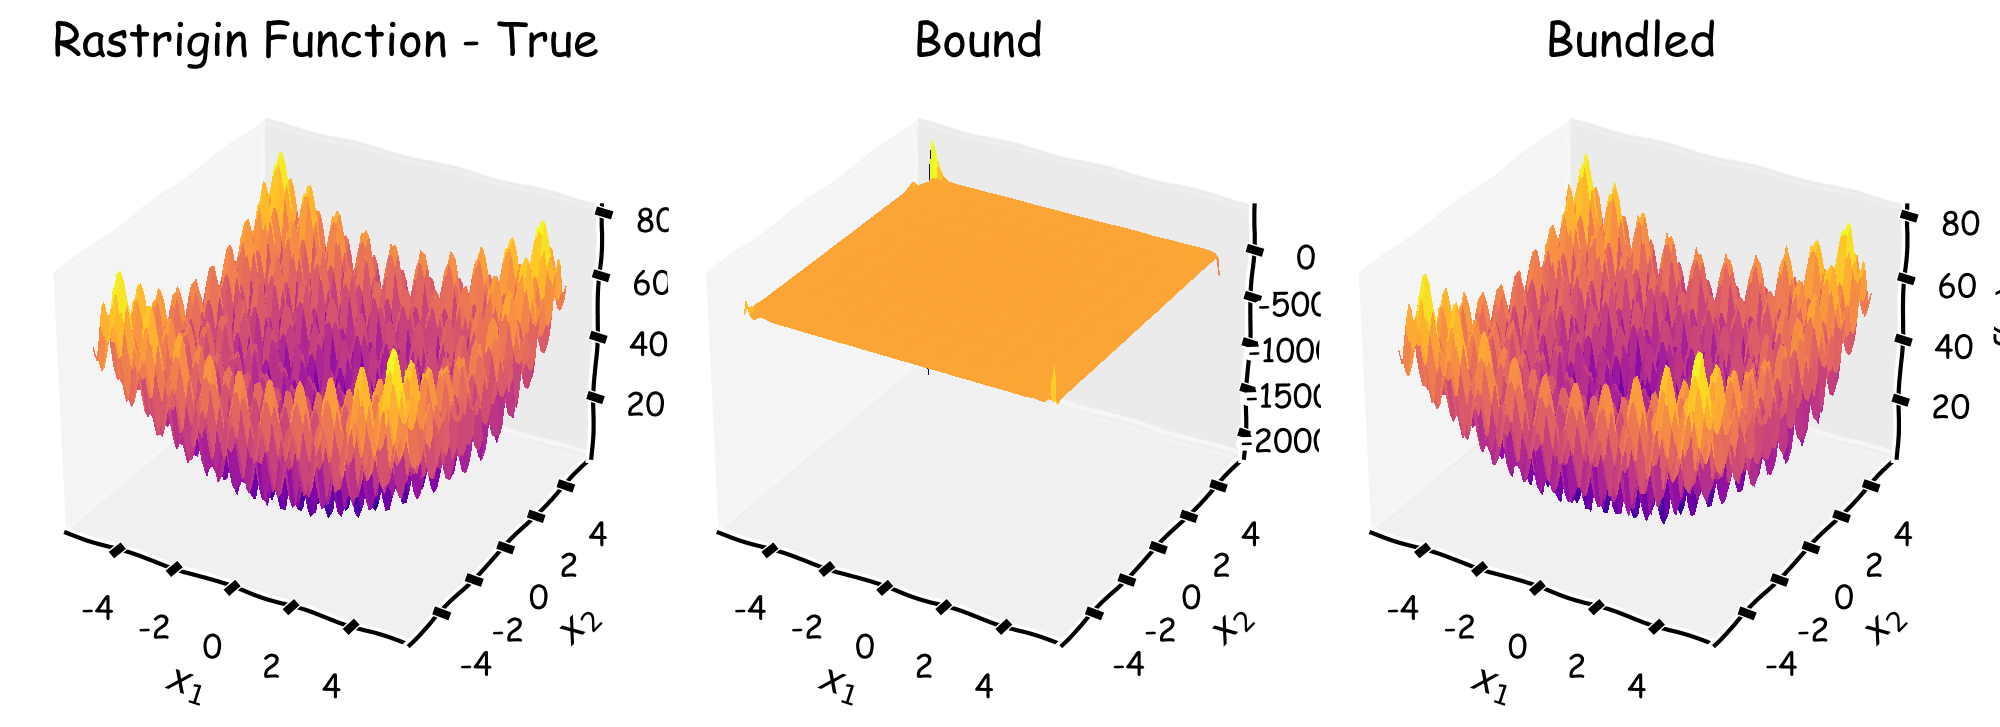

In [27]:
bound_model = get_model(bound_phis, ys_rastrigin, test_size=0.7)
bundled_model = get_model(bundle_phis, ys_rastrigin, test_size=0.7)

ys_hat_rastrigin_bound = bound_model.predict(bound_phis)
ys_hat_rastrigin_bundled = bundled_model.predict(bundle_phis)

plot_3d_function([X, X, X], [Y, Y, Y], [ys_rastrigin.reshape(X.shape), ys_hat_rastrigin_bound.reshape(X.shape), ys_hat_rastrigin_bundled.reshape(X.shape)], ['Rastrigin Function - True', 'Bound', 'Bundled'])

### Coding Exercise 2 Discussion

1. Why do we think bundled representation is superior for Rastrigin function?

In [28]:
#to_remove explanation

"""
Discussion: Why do we think bundled representation is superior for Rastrigin function?

As the name of the coding exercise suggests, we have additive function and, thus, bundling being additive operation is superior to simple bound.
""";

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_additive_function")

## Coding Exercise 3: Non-separable Function

Now let's consider a non-separable function.  We will examine the function $f(\mathbf{x}) = \sin(x_{1}x_{2})$ over the domain $[-4,4]^{2}$.

The same exercise goes here - continue missing parts of the code to get the correct calculation of the defined function.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete the non-separable function.")
###################################################################

def non_separable(x):
    """Compute non-separable function for given array of 2-dimenstional vectors.

    Inputs:
    - x (np.ndarray of shape (n, 2)): n 2-dimensional vectors.

    Outputs:
    - y (np.ndarray of shape (n, 1)): non-separable function value for each of the vectors.
    """
    return np.sin(np.multiply(x[:,...],x[:,...]))

In [29]:
#to_remove solution

def non_separable(x):
    """Compute non-separable function for given array of 2-dimenstional vectors.

    Inputs:
    - x (np.ndarray of shape (n, 2)): n 2-dimensional vectors.

    Outputs:
    - y (np.ndarray of shape (n, 1)): non-separable function value for each of the vectors.
    """
    return np.sin(np.multiply(x[:,0],x[:,1]))

In [30]:
x0 = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x0,x0)
xs = np.vstack((X.flatten(), Y.flatten())).T

ys_non_separable = non_separable(xs)

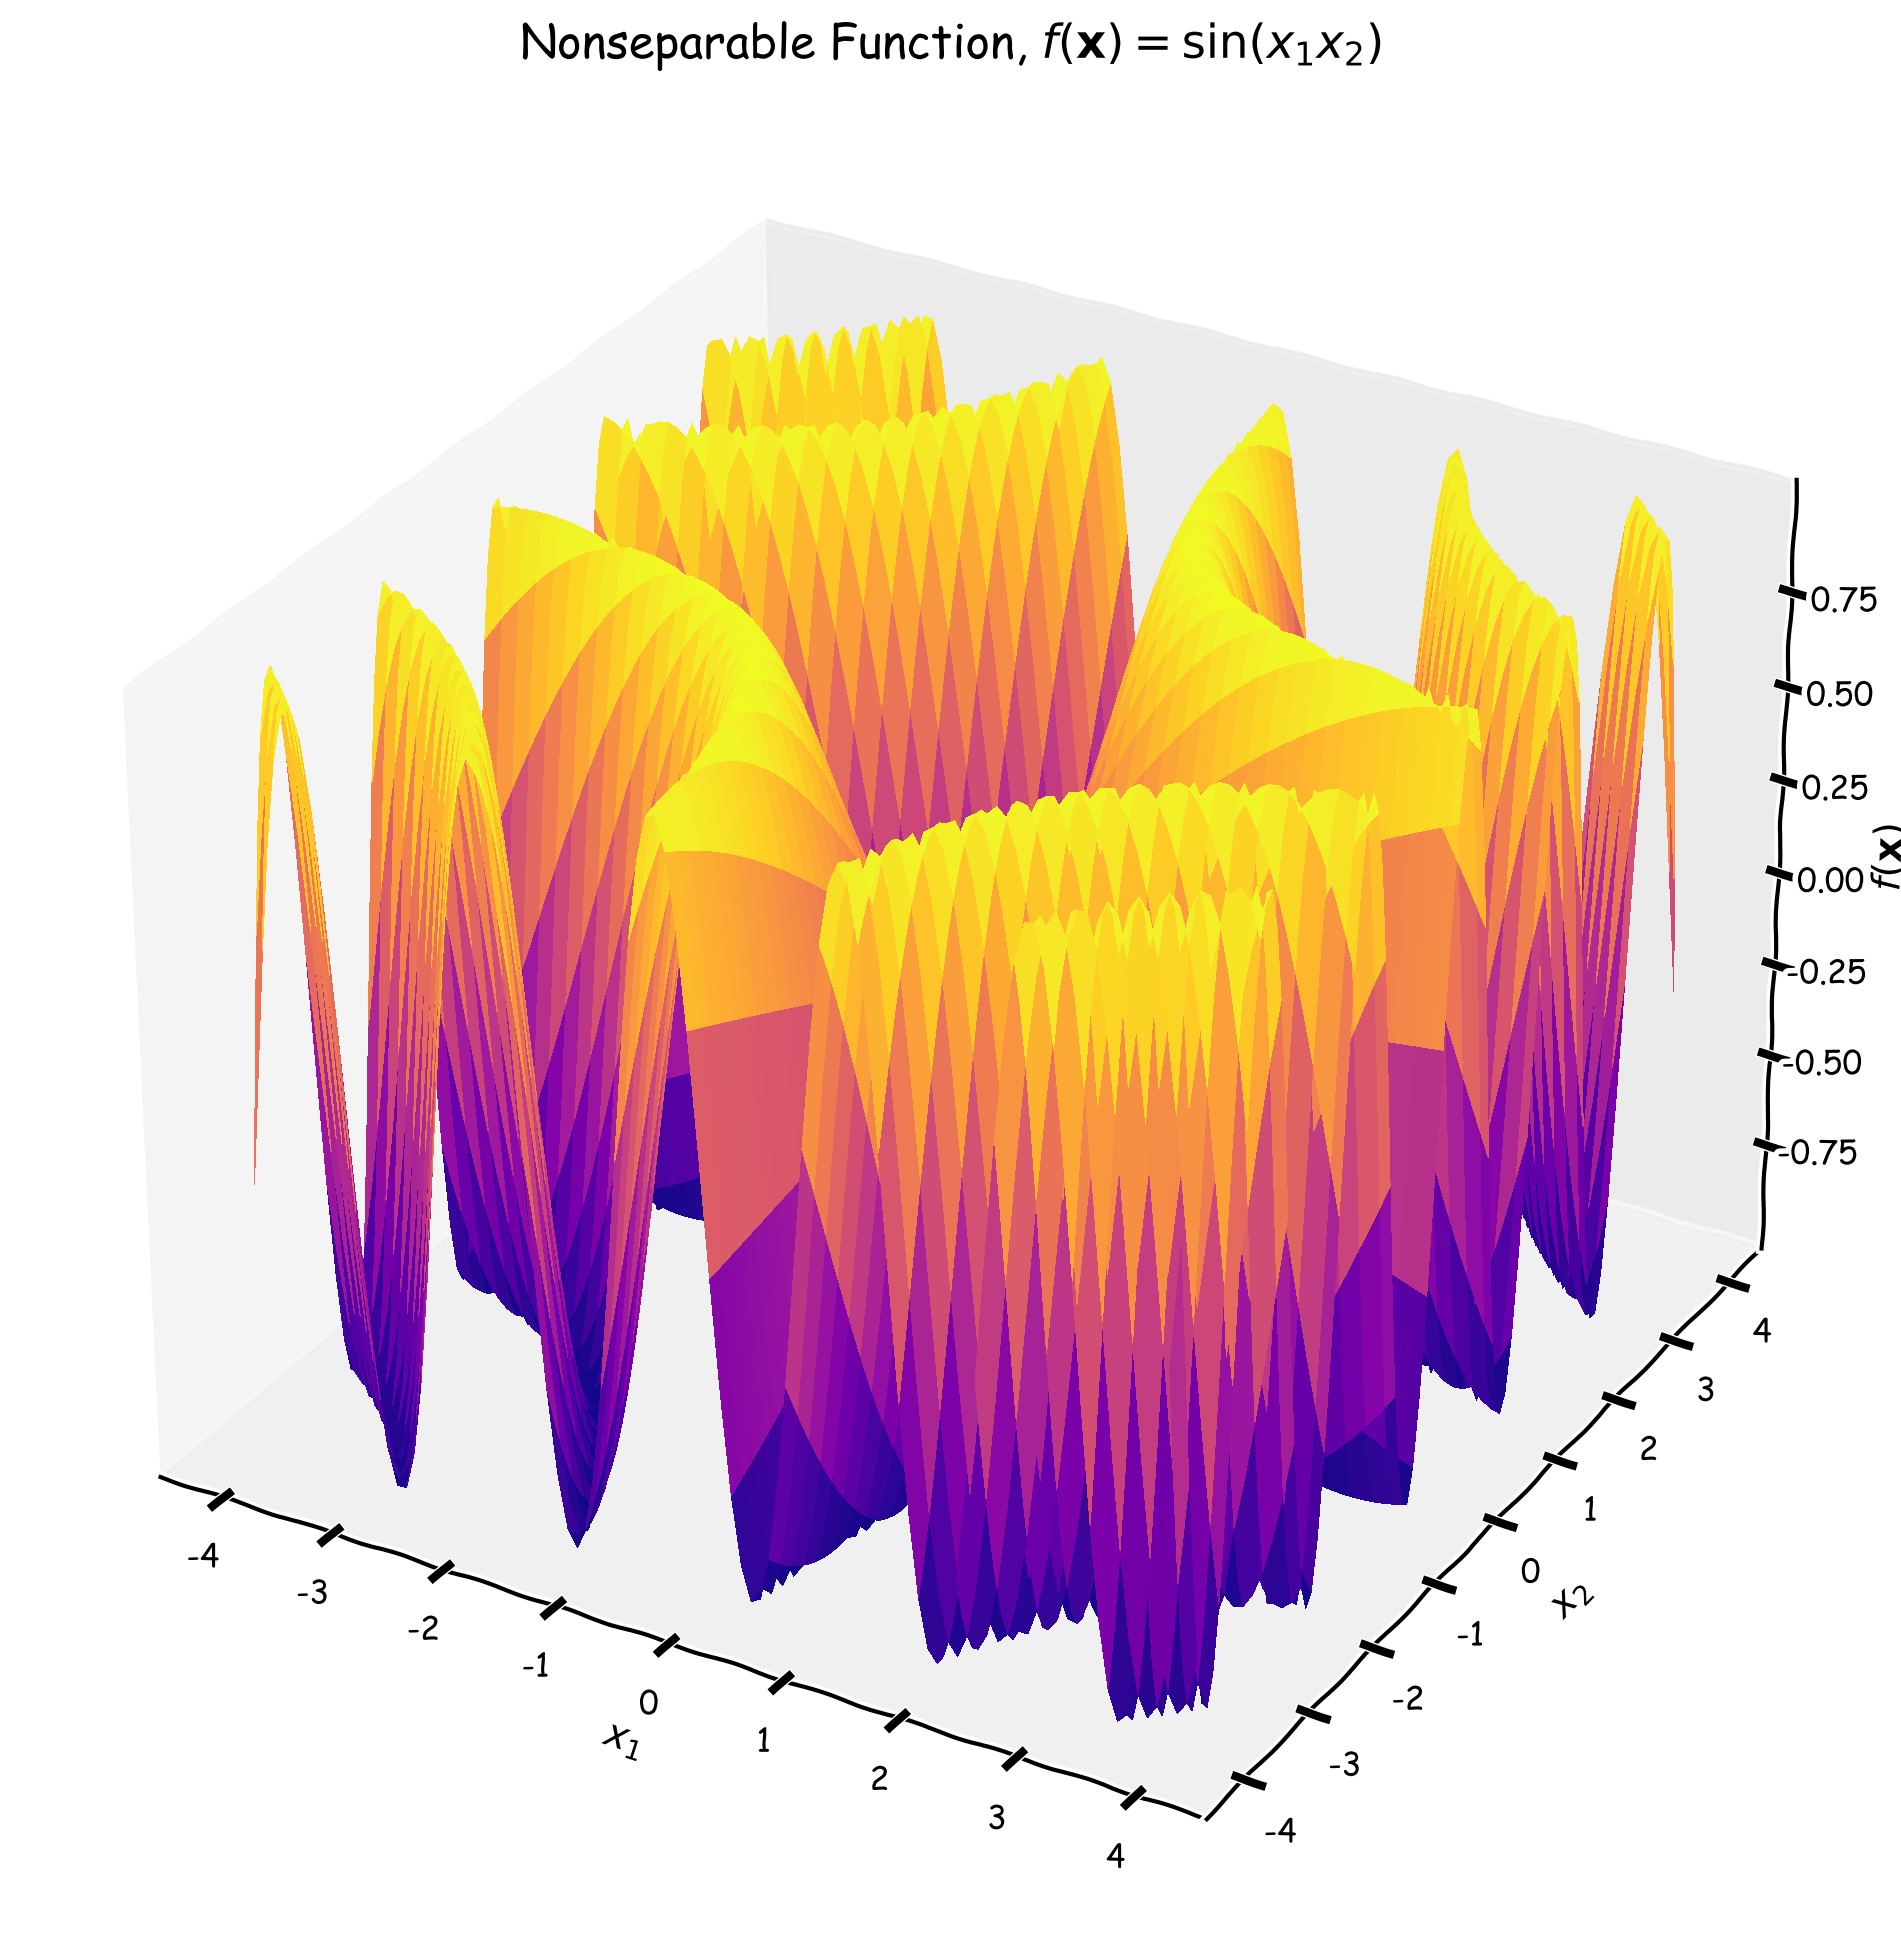

In [31]:
plot_3d_function([X],[Y], [ys_non_separable.reshape(X.shape)], ['Nonseparable Function, $f(\mathbf{x}) = \sin(x_{1}x_{2})$'])

### Coding Exercise 3 Discussion

1. Can you guess by the nature of the function which of the representations will be more efficient?

In [32]:
#to_remove explanation

"""
Discussion: Can you guess by the nature of the function which of the representations will be more efficient?

As here function doesn't have distinct additive parts, we expect bound representation to be better.
""";

We will reuse previously defined spaces for encoding bounded and bundling representations.

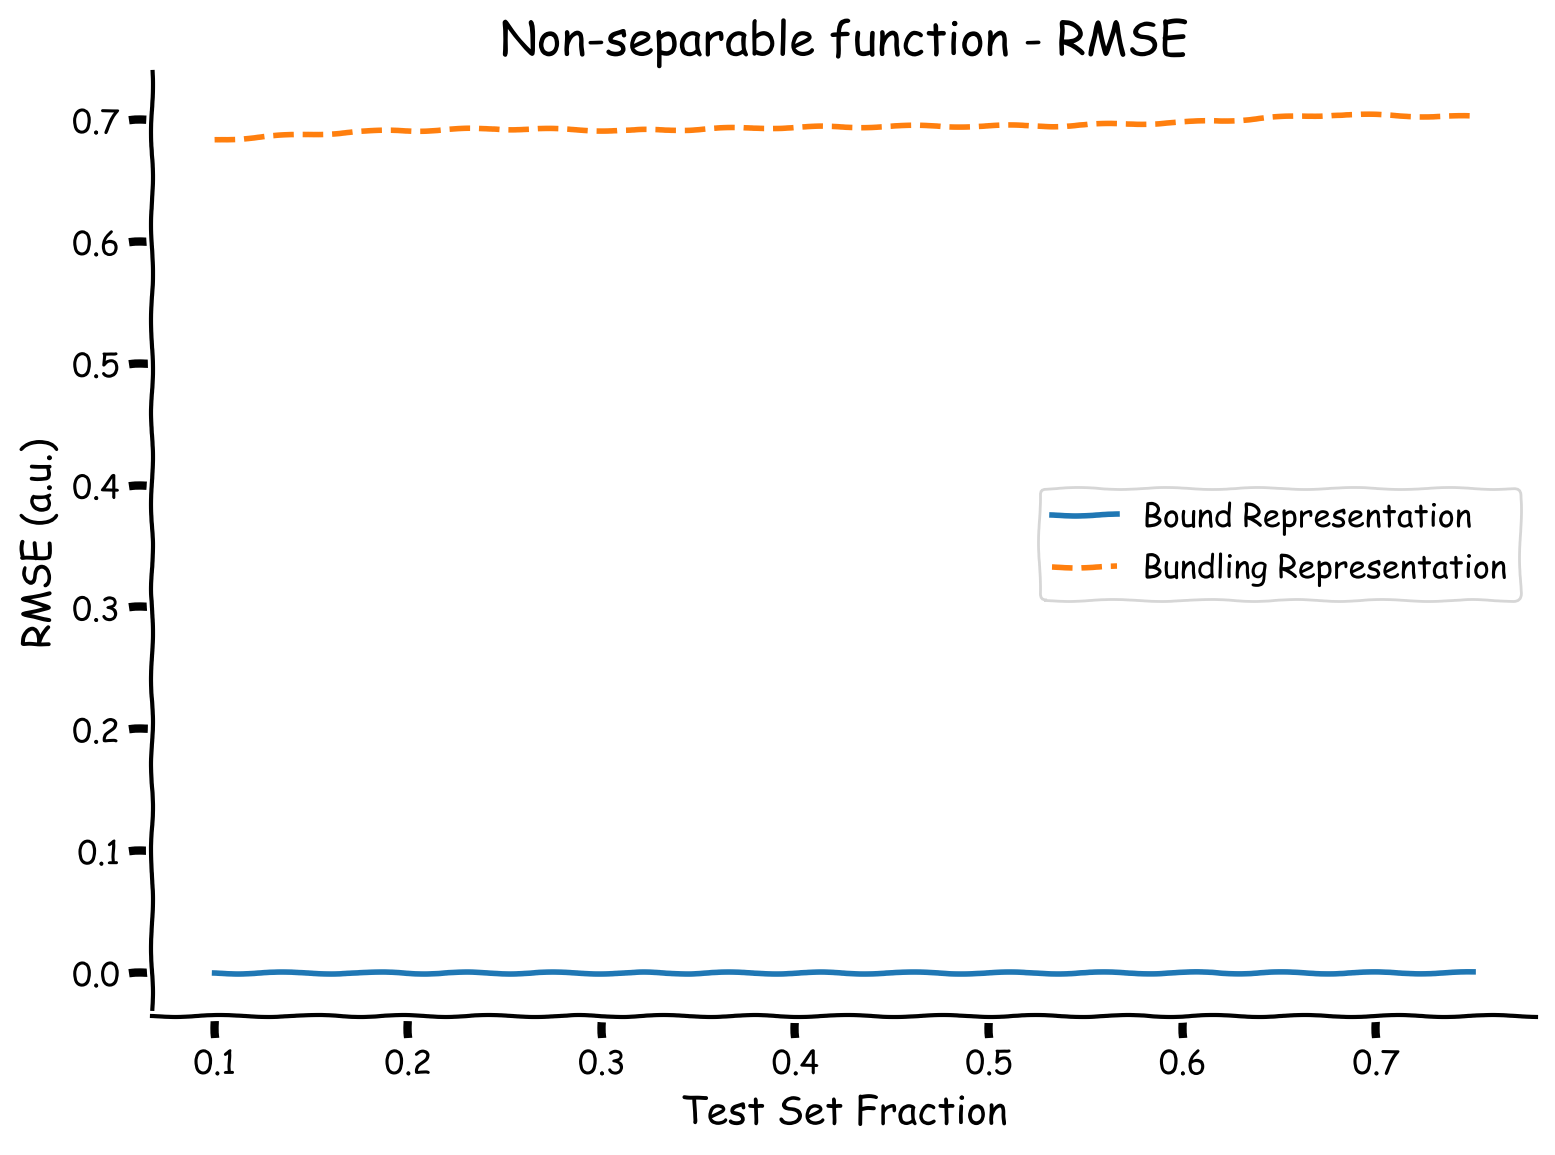

In [33]:
bound_phis = ssp_space.encode(xs)
bundle_phis = ssp_space0.encode(xs[:,0][:,None]) + ssp_space1.encode(xs[:,1][:,None])

test_sizes = np.linspace(0.1,0.75,10)
bound_performance = test_performance(bound_phis, ys_non_separable, test_sizes)
bundle_performance = test_performance(bundle_phis, ys_non_separable, test_sizes)
plot_performance(bound_performance, bundle_performance, test_sizes, title = "Non-separable function - RMSE")

Bundling representation can't achieve the same quality even with the small fraction of test size.

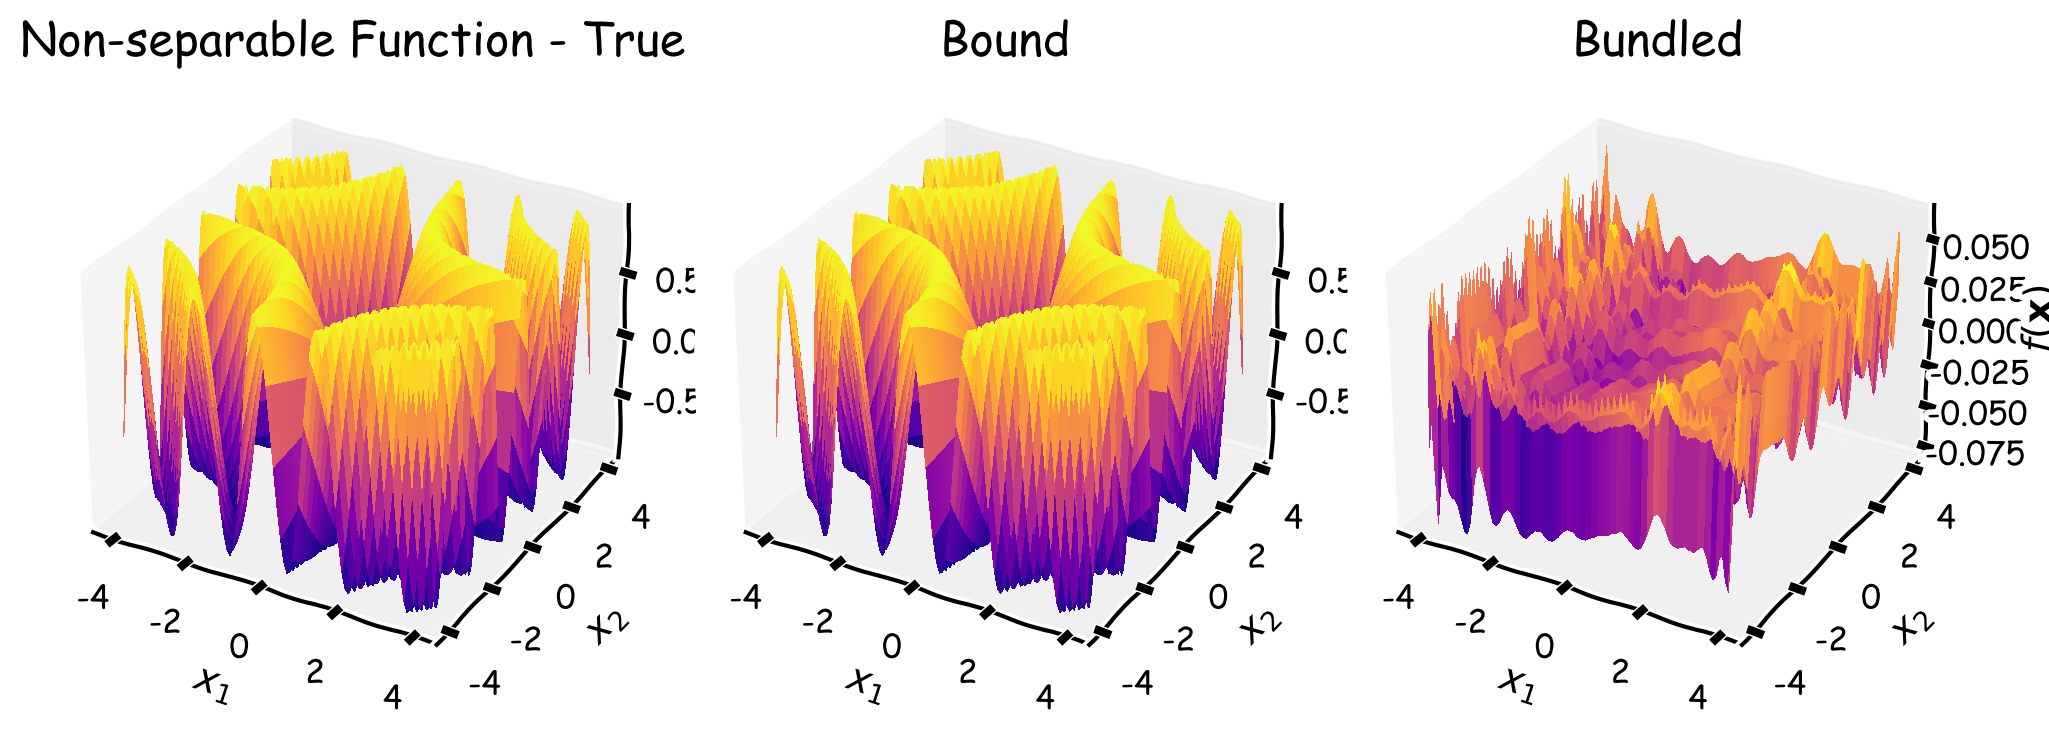

In [34]:
bound_model = get_model(bound_phis, ys_non_separable, 0.75)
bundle_model = get_model(bundle_phis, ys_non_separable, 0.1)

ys_hat_bound = bound_model.predict(bound_phis)
ys_hat_bundle = bundle_model.predict(bundle_phis)

plot_3d_function([X, X, X], [Y, Y, Y], [ys_non_separable.reshape(X.shape), ys_hat_bound.reshape(X.shape), ys_hat_bundle.reshape(X.shape)], ['Non-separable Function - True', 'Bound', 'Bundled'])

So as we can see, when we pick the right inductive bias, we can do a better job.

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_non_separable_function")

---

# Section 3: Representing Continuous Values

Estimated timing to here from start of tutorial: 45 minutes

In this section we will use a technique called Fractional Binding to represent continuous values to construct a map of objects distributed over a 2D space.  

In [ ]:
# @title Video 4: Mapping Intro
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'eyjaQq8y_Ag')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_mapping_intro")

## Coding Exercise 4: Mixing Discrete Objects With Continuous Space

We are going to store three objects in a vector that represents a map. First we are going to create 3 objects (a circle, square, and triangle) like before.

In [35]:
set_seed(42)

obj_names = ['circle','square','triangle']
discrete_space = sspspace.DiscreteSPSpace(obj_names, ssp_dim=1024)

objs = {n:discrete_space.encode(n) for n in obj_names}

Next we are going to create three locations for the objects to reside at and an encoder to transform those coordinates into an SSP representation.

In [36]:
set_seed(42)

ssp_space = sspspace.RandomSSPSpace(domain_dim=2, ssp_dim=1024)
positions = np.array([[0,-2],
                      [-2,3],
                      [3,2]
                     ])
ssps = {n:ssp_space.encode(x) for n, x in zip(obj_names, positions)}

Next, in order to see where things are on the map we are going to compute the similarity between encoded places and points in the space. Your task is to complete calculation of similarity values by proposing correct notation for `np.einsum()` function (remember: we would like to calculate similarity between all grid points with the given one associated with the object).

In [37]:
dim0 = np.linspace(-5,5,101)
dim1 = np.linspace(-5,5,101)
X,Y = np.meshgrid(dim0,dim1)

query_xs = np.vstack((X.flatten(),Y.flatten())).T
query_ssps = ssp_space.encode(query_xs)

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete `np.einsum()` function.")
###################################################################

sims = []

for obj_idx, obj in enumerate(obj_names):
    sims.append(np.einsum(..., ..., ssps[obj].flatten()))

In [38]:
#to_remove solution

sims = []

for obj_idx, obj in enumerate(obj_names):
    sims.append(np.einsum('nd,d->n', query_ssps, ssps[obj].flatten()))

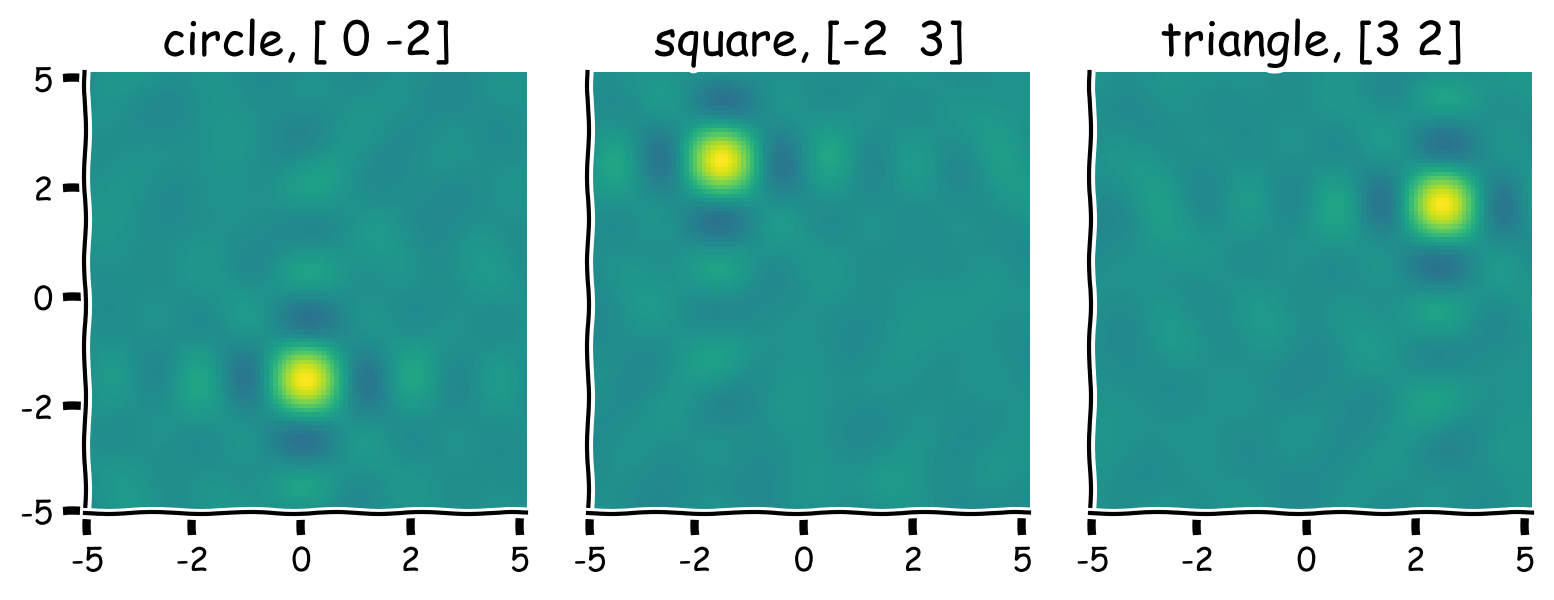

In [39]:
plot_2d_similarity(sims, obj_names, (dim0.size,dim1.size))

Now, let's bind these positions with the objects and see how that changes similarity with the map positions. Complete binding operation in the cell below.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete binding operation for objects and corresponding positions.")
###################################################################

#objects are located in `objs` and positions in `ssps`
bound_objects = [... * ... for n in obj_names]

In [40]:
#to_remove solution

#objects are located in `objs` and positions in `ssps`
bound_objects = [objs[n] * ssps[n] for n in obj_names]

Now we will calculate the similarity in the same way we did it before.

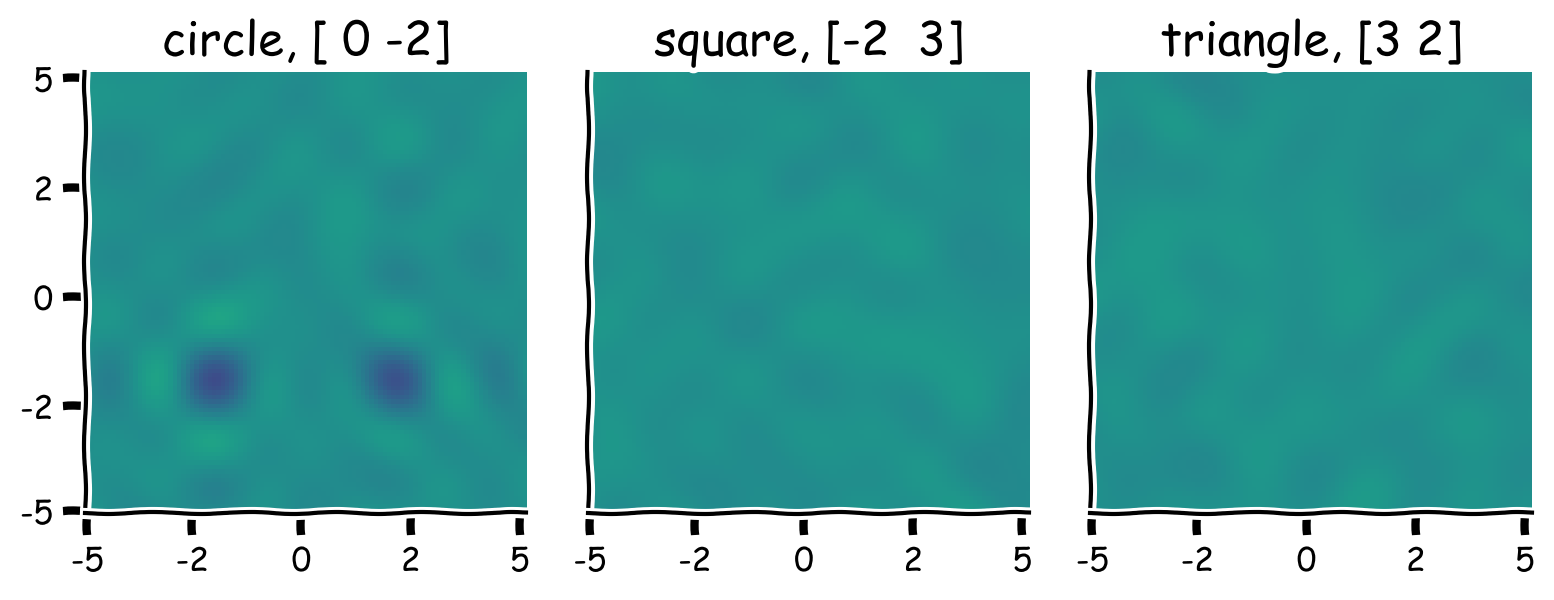

In [41]:
sims = []

for obj_idx, obj in enumerate(obj_names):
    sims.append(np.einsum('nd,d->n', query_ssps, bound_objects[obj_idx].flatten()))
plot_2d_similarity(sims, obj_names, (dim0.size, dim1.size))

As you can seem, the similarity is destroyed, which is what we should expect.

Next, we are going to create a map out of our bound objects:

$$
\mathrm{map} = \sum_{i=1}^{n} \phi(x_{i})\circledast obj_{i}
$$

In [42]:
set_seed(42)

ssp_map = sspspace.SSP(np.sum(bound_objects, axis=0))

Now we can query the map by unbinding the objects we care about. Your task is to complete the unbinding operation.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete the unbinding operation.")
###################################################################

sims = []

for obj_idx, obj_name in enumerate(obj_names):
    #query the object name by unbinding it from the map
    query_map = ssp_map * ~objs[...]
    sims.append(np.einsum('nd,d->n', query_ssps,query_map.flatten()))

In [43]:
#to_remove solution

sims = []

for obj_idx, obj_name in enumerate(obj_names):
    #query the object name by unbinding it from the map
    query_map = ssp_map * ~objs[obj_name]
    sims.append(np.einsum('nd,d->n', query_ssps,query_map.flatten()))

Let's observed the resulting similarities.

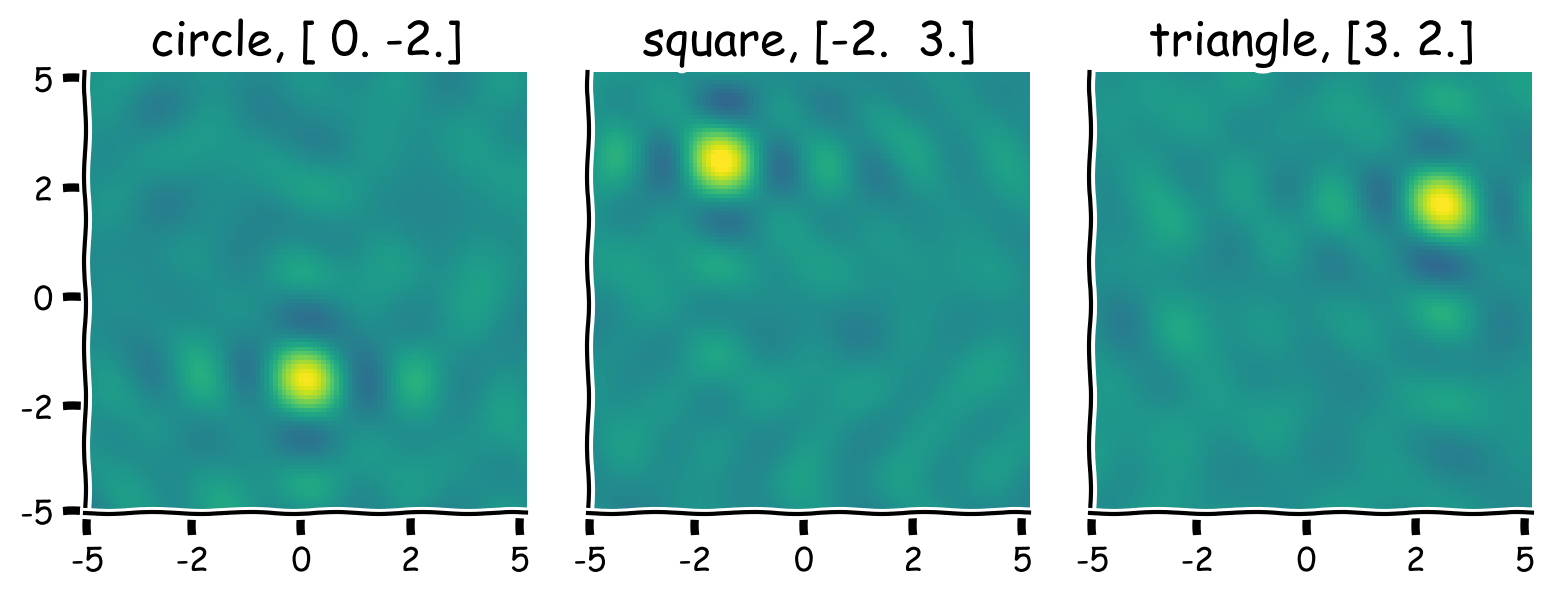

In [44]:
plot_2d_similarity(sims, obj_names, (dim0.size, dim1.size), title_argmax = True)

Let's look at what happens when we unbind all the symbols at once from the map. Complete bundling and unbinding operations in the following code cell.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete the bundling and unbinding operations.")
###################################################################

#unifying bundled representation of all objects
all_objs = (objs['circle'] + objs[...] + objs[...]).normalize()

#unbind this unifying representation from the map
query_map = ... * ~...

In [45]:
#to_remove solution
#unifying bundled representation of all objects
all_objs = (objs['circle'] + objs['square'] + objs['triangle']).normalize()

#unbind this unifying representation from the map
query_map = ssp_map * ~all_objs

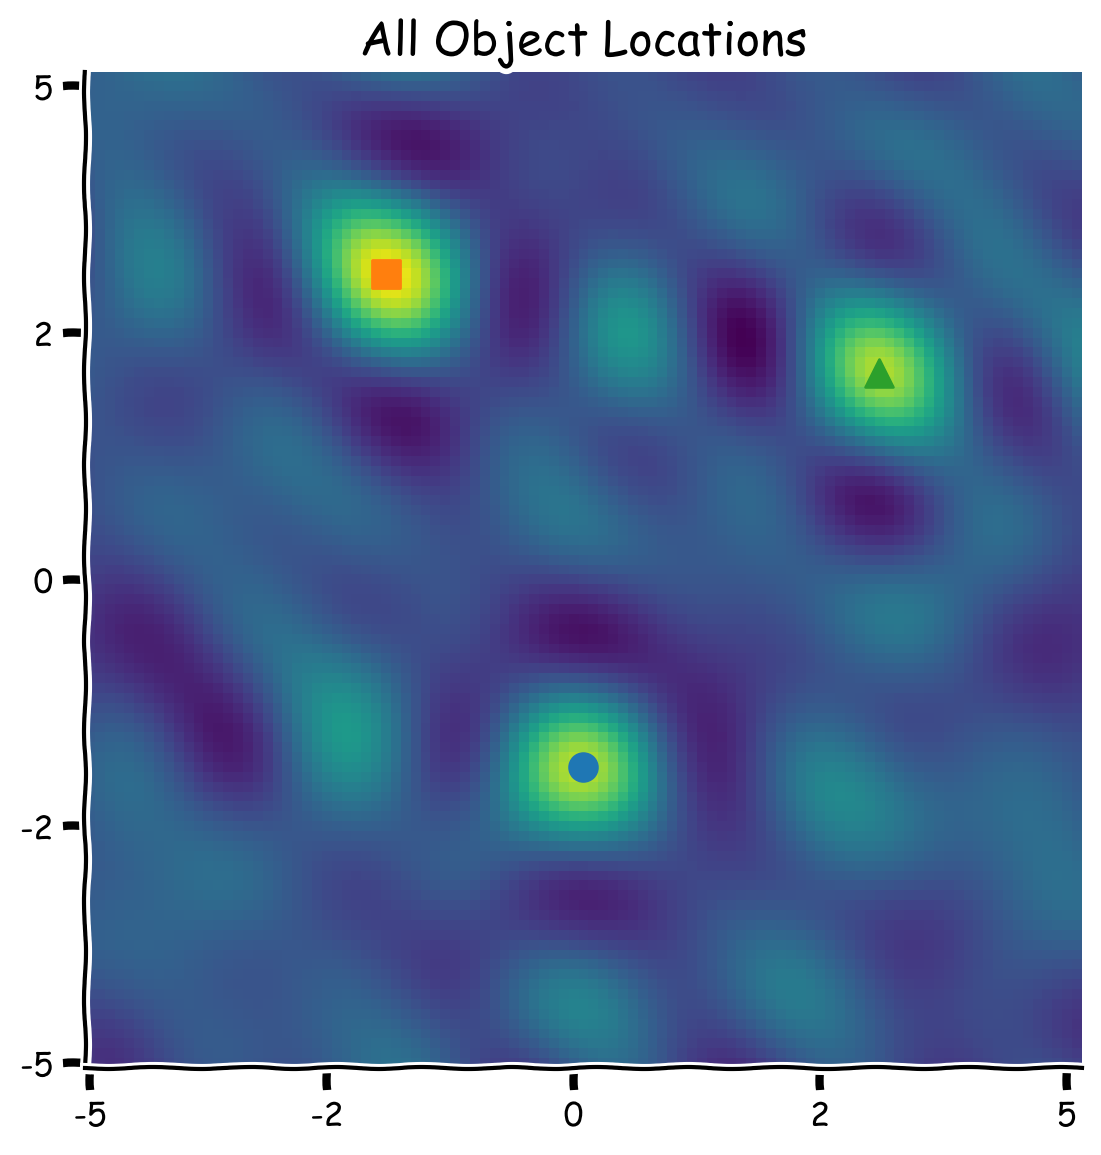

In [46]:
sims = np.einsum('nd,d->n', query_ssps, query_map.flatten())
size = (dim0.size,dim1.size)

plot_unbinding_objects_map(sims, positions, query_xs, size)

But also, we can unbind positions and see what objects exist there. We will use test positions as the ones where objects are located but also two distinct ones to see what will be the result there. In the final exercise you should complete the unbinding of the position operation.

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete the unbinding operations.")
###################################################################

query_objs = np.vstack([objs[n] for n in obj_names])
test_positions = np.vstack((positions, [0,0], [0,-1.5]))

sims = []

for pos_idx, pos in enumerate(test_positions):
    position_ssp = ssp_space.encode(pos[None,:]) #remember we need to have 2-dimensional vectors for `encode()` function
    #unbind positions from the map
    query_map = ... * ~...
    sims.append(np.einsum('nd,d->n', query_objs,query_map.flatten()))

In [47]:
#to_remove solution

query_objs = np.vstack([objs[n] for n in obj_names])
test_positions = np.vstack((positions, [0,0], [0,-1.5]))

sims = []

for pos_idx, pos in enumerate(test_positions):
    position_ssp = ssp_space.encode(pos[None,:]) #remember we need to have 2-dimensional vectors for `encode()` function
    #unbind positions from the map
    query_map = ssp_map * ~position_ssp
    sims.append(np.einsum('nd,d->n', query_objs,query_map.flatten()))

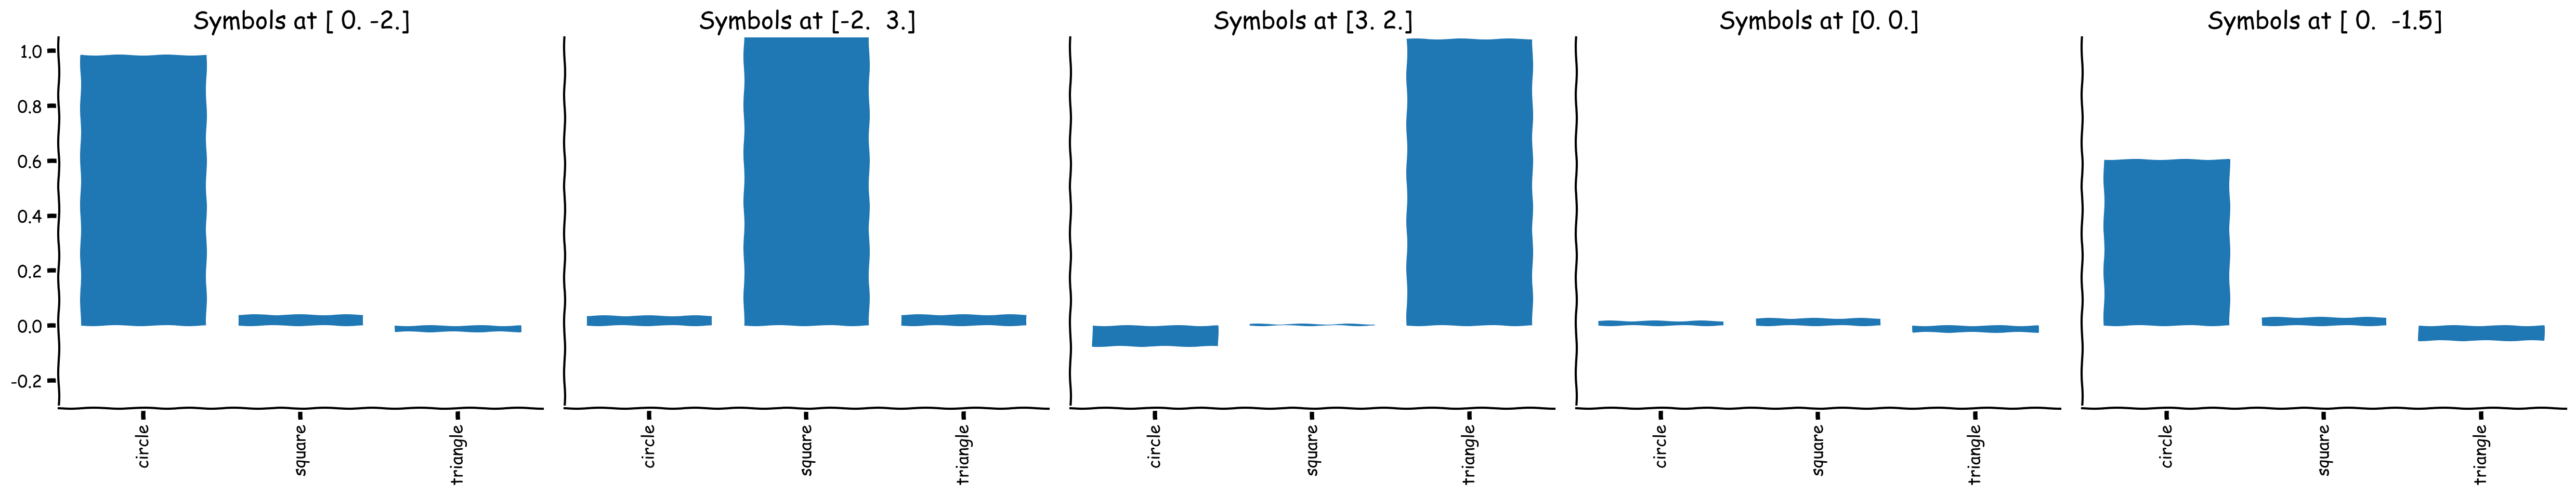

In [48]:
plot_unbinding_positions_map(sims, test_positions, obj_names)

As you can see from the above plots, when you query what is at the locations of the particular location, we can clearly identify which object is stored at which location.  

When we query at the origin (where no object is present) we see that there is no strong candidate element.  But as we move closer to one of the objects (rightmost plot) the similarity starts to increase.

In [49]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_mixing_discrete_objects_with_continuous_space")

In [ ]:
# @title Video 13: Mapping Outro
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'xeFzv1sMdZY')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_mapping_outro")

---
# Summary

*Estimated timing of tutorial: 1 hour 20 minutes*

In [ ]:
# @title Video 14: Conclusions
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '68JKXf37-YM')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Conclusion slides

from IPython.display import IFrame
link_id = "y3zua"

print(f"If you want to download the slides: 'https://osf.io/download/{link_id}'")

IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_conclusions")